In [ ]:
 n#Clone github repository to download dataset
!git clone https://github.com/BhatnagarKshitij/PCOS-detection.git

Cloning into 'PCOS-detection'...
remote: Enumerating objects: 1932, done.
remote: Total 1932 (delta 0), reused 0 (delta 0), pack-reused 1932
Receiving objects: 100% (1932/1932), 62.56 MiB | 29.44 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (3857/3857), done.


In [ ]:
#Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten , Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
trainingDirectory="/content/PCOS-detection/data/train"


train_ds=image_dataset_from_directory(
    trainingDirectory,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=True,
    crop_to_aspect_ratio=False,
)

Found 1924 files belonging to 2 classes.


<ipython-input-5-1a8cc1648e20>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(6, 6, i + 1)


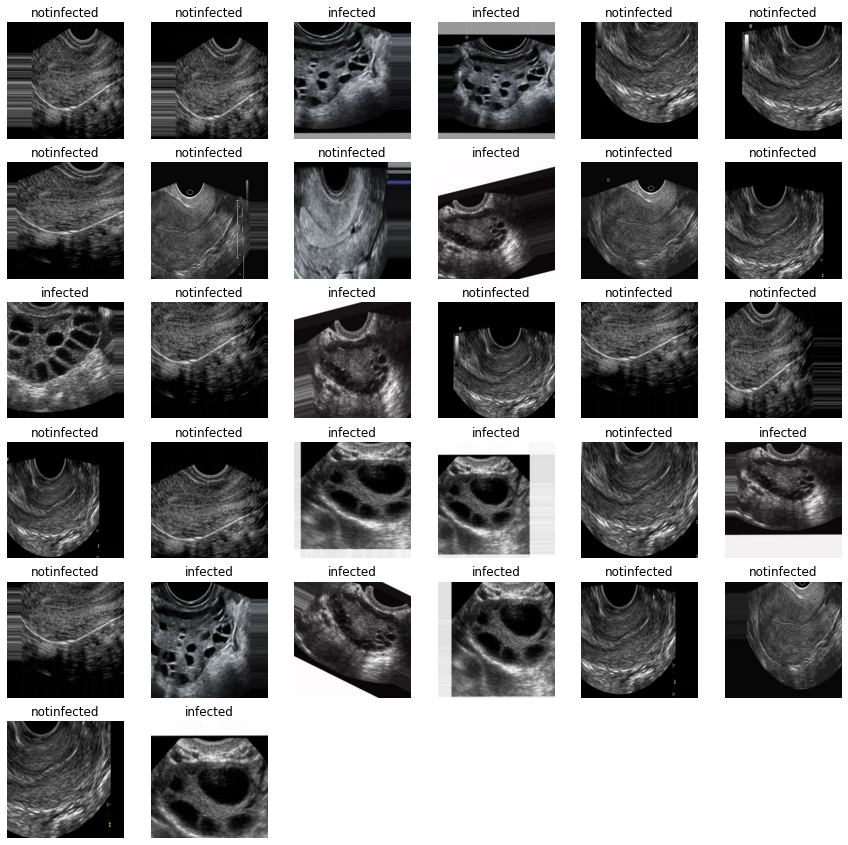

In [ ]:
#Visualization
plt.figure(figsize=(15, 15))
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
# create generator
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.3,
                             fill_mode='nearest'
                             )

In [ ]:
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory( trainingDirectory,
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=32, #100
                                       subset='training',
                                       seed=24)

Found 1348 images belonging to 2 classes.


In [ ]:
# prepare an iterators for each dataset
val_it = datagen.flow_from_directory( trainingDirectory,
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=32,
                                       subset='validation',
                                       seed=24)

Found 576 images belonging to 2 classes.


In [ ]:
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchy.shape, batchy.min(), batchy.max()))
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(32, 2), min=0.000, max=1.000
Batch shape=(32, 224, 224, 3), min=0.000, max=1.000


In [ ]:
model1 = Sequential()
model1.add(Conv2D(10, (5,5),padding='valid',activation='relu',input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=(4,4)))
# REPEAT CONV AND POOLING layer 3 TIMES
model1.add(Conv2D(12, (5,5),padding='valid',activation='relu'))
model1.add(MaxPooling2D(pool_size=(4,4)))
#model1.add(Conv2D(128, (5,5),padding='valid',activation='relu'))
# model1.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
# model1.add(MaxPooling2D(pool_size=(4,4)))
model1.add(Flatten())
#model1.add(Dense(128,activation='relu'))
#model1.add(Dense(64,activation='relu'))
model1.add(Dense(2,activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 10)      760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 12)        3012      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 12)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1728)              0         
                                                                 
 dense (Dense)               (None, 2)                 3

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model1.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model1.fit(
  train_it,
  validation_data=val_it,
  epochs=10)

Epoch 1/10
43/43 [==============================] - 32s 571ms/step - loss: 0.4755 - accuracy: 0.8019 - val_loss: 0.2697 - val_accuracy: 0.9149
Epoch 2/10
43/43 [==============================] - 25s 592ms/step - loss: 0.1483 - accuracy: 0.9525 - val_loss: 0.0825 - val_accuracy: 0.9705
Epoch 3/10
43/43 [==============================] - 24s 572ms/step - loss: 0.0511 - accuracy: 0.9896 - val_loss: 0.0759 - val_accuracy: 0.9688
Epoch 4/10
43/43 [==============================] - 25s 575ms/step - loss: 0.0272 - accuracy: 0.9941 - val_loss: 0.0234 - val_accuracy: 0.9913
Epoch 5/10
43/43 [==============================] - 24s 571ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9913
Epoch 6/10
43/43 [==============================] - 24s 565ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9983
Epoch 7/10
43/43 [==============================] - 24s 567ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0079 - val_accuracy: 0.9983

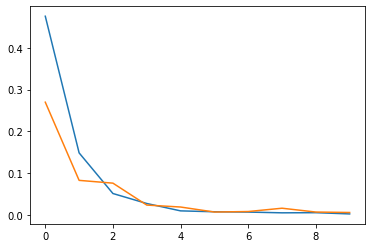

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
